## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from google.colab import drive

from nltk.stem import WordNetLemmatizer

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Opening JSON file 
f = open('gdrive/My Drive/NLP/complaints-2021-05-14_08_16.json','r')# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [5]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [6]:
#Assign new column names
df_complaints = df[['_source.complaint_what_happened']]
df_complaints.rename(columns = {'_source.complaint_what_happened':'complaints'}, inplace = True)
df_complaints.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,complaints
0,
1,Good morning my name is XXXX XXXX and I apprec...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...
3,
4,


In [7]:
#Assign nan in place of blanks in the complaints column
print(df_complaints.isna().sum())

complaints    0
dtype: int64


In [8]:
#Remove all rows where complaints column is nan
df_complaints = df_complaints[df_complaints['complaints'] != '']

In [9]:
df_complaints.shape

(21072, 1)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [10]:
# Write your function here to clean the text and remove all the unnecessary elements.
df_complaints['complaints'] = df_complaints['complaints'].str.lower()

def square_brackets(x):
  '''
  Function to remove square brackets
  '''
  x = str(x)
  return re.sub("\[.*?\]","",x)

def punctuations(x):
  '''
  Function to remove square punctuations
  '''
  x = str(x)
  return re.sub(r'[^\w\s]', '', x)

def digits(x):
  '''
  Function to remove digits
  '''
  x = str(x)
  return re.sub(r'[~^0-9]', '', x)

df_complaints['complaints'] = df_complaints['complaints'].apply(square_brackets)
df_complaints['complaints'] = df_complaints['complaints'].apply(punctuations)
df_complaints['complaints'] = df_complaints['complaints'].apply(digits)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:
df_complaints

,complaints
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in xxxx and was t...
10,chase card was reported on xxxx however fraudu...
11,on xxxx while trying to book a xxxx xxxx tic...
14,my grand son give me check for i deposit it i...
...,...
78303,after being a chase card customer for well ove...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...
78310,i am not familiar with xxxx pay and did not un...
78311,i have had flawless credit for yrs ive had ch...


In [12]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
#Write your function to Lemmatize the texts

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

In [14]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 

df_clean = df_complaints.copy()

df_clean['lemmatized_complaints'] = df_clean['complaints'].apply(lemmatize_text)
df_clean['lemmatized_complaints'] = df_clean['lemmatized_complaints'].apply(lambda x: ' '.join(map(str, x)))

In [15]:
df_clean

,complaints,lemmatized_complaints
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in xxxx and was t...,i upgraded my xxxx xxxx card in xxxx and wa to...
10,chase card was reported on xxxx however fraudu...,chase card wa reported on xxxx however fraudul...
11,on xxxx while trying to book a xxxx xxxx tic...,on xxxx while trying to book a xxxx xxxx ticke...
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...
...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...
78311,i have had flawless credit for yrs ive had ch...,i have had flawless credit for yr ive had chas...


In [16]:
df_clean['lemmatized_complaints'].apply(lambda item:item.strip().split()).apply(nltk.pos_tag)

1        [(good, JJ), (morning, NN), (my, PRP$), (name,...
2        [(i, NN), (upgraded, VBD), (my, PRP$), (xxxx, ...
10       [(chase, JJ), (card, NN), (wa, NN), (reported,...
11       [(on, IN), (xxxx, NNP), (while, IN), (trying, ...
14       [(my, PRP$), (grand, JJ), (son, NN), (give, VB...
                               ...                        
78303    [(after, IN), (being, VBG), (a, DT), (chase, N...
78309    [(on, IN), (wednesday, JJ), (xxxxxxxx, NN), (i...
78310    [(i, NN), (am, VBP), (not, RB), (familiar, JJ)...
78311    [(i, NN), (have, VBP), (had, VBN), (flawless, ...
78312    [(roughly, RB), (year, NN), (ago, IN), (i, NN)...
Name: lemmatized_complaints, Length: 21072, dtype: object

In [17]:
#Write your function to extract the POS tags 

df_clean['POS_Tagged_Text'] = df_clean['lemmatized_complaints'].apply(lambda item:item.strip().split()).apply(nltk.pos_tag)


In [18]:
df_clean["complaint_POS_removed"] = df_clean['POS_Tagged_Text'].apply(lambda item:[w for w,t in item if t=='NN'])

In [19]:
df_clean

,complaints,lemmatized_complaints,POS_Tagged_Text,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,"[(good, JJ), (morning, NN), (my, PRP$), (name,...","[morning, name, stop, bank, cardmember, servic..."
2,i upgraded my xxxx xxxx card in xxxx and was t...,i upgraded my xxxx xxxx card in xxxx and wa to...,"[(i, NN), (upgraded, VBD), (my, PRP$), (xxxx, ...","[i, card, wa, agent, upgrade, date, agent, wa,..."
10,chase card was reported on xxxx however fraudu...,chase card wa reported on xxxx however fraudul...,"[(chase, JJ), (card, NN), (wa, NN), (reported,...","[card, wa, xxxx, application, identity, consen..."
11,on xxxx while trying to book a xxxx xxxx tic...,on xxxx while trying to book a xxxx xxxx ticke...,"[(on, IN), (xxxx, NNP), (while, IN), (trying, ...","[book, xxxx, ticket, i, offer, ticket, card, i..."
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,"[(my, PRP$), (grand, JJ), (son, NN), (give, VB...","[son, deposit, chase, account, fund, chase, ba..."
...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,"[(after, IN), (being, VBG), (a, DT), (chase, N...","[chase, card, customer, decade, wa, solicitati..."
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,"[(on, IN), (wednesday, JJ), (xxxxxxxx, NN), (i...","[xxxxxxxx, i, chas, visa, credit, card, provid..."
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,"[(i, NN), (am, VBP), (not, RB), (familiar, JJ)...","[i, pay, risk, consumer, i, bank, app, chase, ..."
78311,i have had flawless credit for yrs ive had ch...,i have had flawless credit for yr ive had chas...,"[(i, NN), (have, VBP), (had, VBN), (flawless, ...","[i, credit, credit, card, chase, freedom, xxxx..."


In [20]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaints,lemmatized_complaints,POS_Tagged_Text,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,"[(good, JJ), (morning, NN), (my, PRP$), (name,...","[morning, name, stop, bank, cardmember, servic..."
2,i upgraded my xxxx xxxx card in xxxx and was t...,i upgraded my xxxx xxxx card in xxxx and wa to...,"[(i, NN), (upgraded, VBD), (my, PRP$), (xxxx, ...","[i, card, wa, agent, upgrade, date, agent, wa,..."
10,chase card was reported on xxxx however fraudu...,chase card wa reported on xxxx however fraudul...,"[(chase, JJ), (card, NN), (wa, NN), (reported,...","[card, wa, xxxx, application, identity, consen..."
11,on xxxx while trying to book a xxxx xxxx tic...,on xxxx while trying to book a xxxx xxxx ticke...,"[(on, IN), (xxxx, NNP), (while, IN), (trying, ...","[book, xxxx, ticket, i, offer, ticket, card, i..."
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,"[(my, PRP$), (grand, JJ), (son, NN), (give, VB...","[son, deposit, chase, account, fund, chase, ba..."
...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,"[(after, IN), (being, VBG), (a, DT), (chase, N...","[chase, card, customer, decade, wa, solicitati..."
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,"[(on, IN), (wednesday, JJ), (xxxxxxxx, NN), (i...","[xxxxxxxx, i, chas, visa, credit, card, provid..."
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,"[(i, NN), (am, VBP), (not, RB), (familiar, JJ)...","[i, pay, risk, consumer, i, bank, app, chase, ..."
78311,i have had flawless credit for yrs ive had ch...,i have had flawless credit for yr ive had chas...,"[(i, NN), (have, VBP), (had, VBN), (flawless, ...","[i, credit, credit, card, chase, freedom, xxxx..."


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




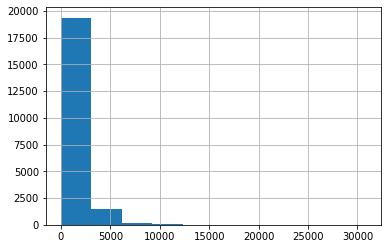

In [21]:
# Write your code here to visualise the data according to the 'Complaint' character length

df_clean['complaints'].str.len().hist()

#### Find the top 40 words by frequency among all the articles after processing the text.

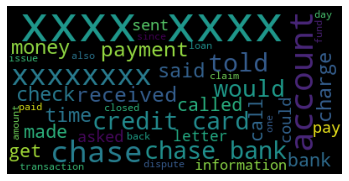

In [22]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

from nltk.corpus import stopwords
from wordcloud import WordCloud

stops = set(stopwords.words('english'))
wc = WordCloud(stopwords = stops , max_words=40).generate(' '.join(df_clean['complaints']))
fig = plt.figure(1)
plt.imshow(wc)
plt.axis('off')
plt.show()


In [23]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [24]:
df_clean

,complaints,lemmatized_complaints,POS_Tagged_Text,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,"[(good, JJ), (morning, NN), (my, PRP$), (name,...","[morning, name, stop, bank, cardmember, servic...",NaN
2,i upgraded my xxxx xxxx card in xxxx and was t...,i upgraded my xxxx xxxx card in xxxx and wa to...,"[(i, NN), (upgraded, VBD), (my, PRP$), (xxxx, ...","[i, card, wa, agent, upgrade, date, agent, wa,...",NaN
10,chase card was reported on xxxx however fraudu...,chase card wa reported on xxxx however fraudul...,"[(chase, JJ), (card, NN), (wa, NN), (reported,...","[card, wa, xxxx, application, identity, consen...",NaN
11,on xxxx while trying to book a xxxx xxxx tic...,on xxxx while trying to book a xxxx xxxx ticke...,"[(on, IN), (xxxx, NNP), (while, IN), (trying, ...","[book, xxxx, ticket, i, offer, ticket, card, i...",NaN
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,"[(my, PRP$), (grand, JJ), (son, NN), (give, VB...","[son, deposit, chase, account, fund, chase, ba...",NaN
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,"[(after, IN), (being, VBG), (a, DT), (chase, N...","[chase, card, customer, decade, wa, solicitati...",NaN
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,"[(on, IN), (wednesday, JJ), (xxxxxxxx, NN), (i...","[xxxxxxxx, i, chas, visa, credit, card, provid...",NaN
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,"[(i, NN), (am, VBP), (not, RB), (familiar, JJ)...","[i, pay, risk, consumer, i, bank, app, chase, ...",NaN
78311,i have had flawless credit for yrs ive had ch...,i have had flawless credit for yr ive had chas...,"[(i, NN), (have, VBP), (had, VBN), (flawless, ...","[i, credit, credit, card, chase, freedom, xxxx...",NaN


In [25]:
df_clean['complaint_POS_removed']

1        [morning, name, stop, bank, cardmember, servic...
2        [i, card, wa, agent, upgrade, date, agent, wa,...
10       [card, wa, xxxx, application, identity, consen...
11       [book, xxxx, ticket, i, offer, ticket, card, i...
14       [son, deposit, chase, account, fund, chase, ba...
                               ...                        
78303    [chase, card, customer, decade, wa, solicitati...
78309    [xxxxxxxx, i, chas, visa, credit, card, provid...
78310    [i, pay, risk, consumer, i, bank, app, chase, ...
78311    [i, credit, credit, card, chase, freedom, xxxx...
78312    [year, i, account, jp, bank, xxxx, order, line...
Name: complaint_POS_removed, Length: 21072, dtype: object

In [59]:
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].apply(lambda x: ' '.join(map(str, x)))

In [27]:
def gram_freq(num1, num2, top):
    corpus = df_clean['complaint_POS_removed'].copy()
    vec = CountVectorizer(ngram_range=(num1,num2)).fit(corpus)
    bow = vec.transform(corpus)
    sum_words = bow.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top]

In [28]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
gram_freq(1,1,30)

[('chase', 51143),
 ('account', 47649),
 ('xxxx', 43062),
 ('credit', 33095),
 ('wa', 32953),
 ('card', 29595),
 ('bank', 28234),
 ('payment', 21175),
 ('time', 16044),
 ('xxxxxxxx', 13266),
 ('day', 13243),
 ('charge', 12240),
 ('money', 11961),
 ('loan', 10986),
 ('check', 10171),
 ('letter', 9679),
 ('information', 9654),
 ('fee', 8686),
 ('transaction', 8650),
 ('number', 8605),
 ('month', 8522),
 ('year', 8399),
 ('amount', 8363),
 ('mortgage', 8179),
 ('customer', 8163),
 ('ha', 8161),
 ('balance', 7758),
 ('company', 7630),
 ('service', 7595),
 ('phone', 7589)]

In [29]:
#Print the top 10 words in the unigram frequency
gram_freq(1,1,10)

[('chase', 51143),
 ('account', 47649),
 ('xxxx', 43062),
 ('credit', 33095),
 ('wa', 32953),
 ('card', 29595),
 ('bank', 28234),
 ('payment', 21175),
 ('time', 16044),
 ('xxxxxxxx', 13266)]

In [30]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
gram_freq(2,2,30)

[('credit card', 12826),
 ('xxxx xxxx', 4539),
 ('credit report', 3876),
 ('customer service', 3085),
 ('chase credit', 3080),
 ('chase account', 2939),
 ('chase bank', 2856),
 ('account wa', 2847),
 ('bank account', 2802),
 ('account chase', 2739),
 ('account account', 2267),
 ('xxxx chase', 1816),
 ('account xxxx', 1679),
 ('checking account', 1663),
 ('phone call', 1631),
 ('credit score', 1629),
 ('account bank', 1600),
 ('card wa', 1598),
 ('card account', 1596),
 ('debit card', 1560),
 ('wa account', 1513),
 ('chase ha', 1510),
 ('wa xxxx', 1481),
 ('wa chase', 1464),
 ('card chase', 1394),
 ('xxxx account', 1391),
 ('account credit', 1389),
 ('credit bureau', 1298),
 ('interest rate', 1296),
 ('money account', 1285)]

In [31]:
#Print the top 10 words in the bigram frequency
gram_freq(2,2,10)

[('credit card', 12826),
 ('xxxx xxxx', 4539),
 ('credit report', 3876),
 ('customer service', 3085),
 ('chase credit', 3080),
 ('chase account', 2939),
 ('chase bank', 2856),
 ('account wa', 2847),
 ('bank account', 2802),
 ('account chase', 2739)]

In [32]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
gram_freq(3,3,30)

[('chase credit card', 2114),
 ('credit card account', 1047),
 ('credit card company', 987),
 ('credit card chase', 676),
 ('inquiry credit report', 516),
 ('xxxx xxxx xxxx', 477),
 ('credit card credit', 468),
 ('xxxx credit card', 411),
 ('account credit card', 403),
 ('credit reporting agency', 388),
 ('bank credit card', 382),
 ('credit card bank', 353),
 ('card credit card', 351),
 ('credit report credit', 350),
 ('credit card xxxx', 345),
 ('charge credit card', 343),
 ('credit card wa', 338),
 ('credit reporting act', 329),
 ('account credit report', 307),
 ('chase customer service', 286),
 ('credit card payment', 283),
 ('customer service representative', 282),
 ('account chase account', 266),
 ('wa credit card', 251),
 ('credit card balance', 251),
 ('chase bank account', 248),
 ('victim identity theft', 247),
 ('consumer protection bureau', 245),
 ('chase fraud department', 243),
 ('credit card card', 239)]

In [33]:
#Print the top 10 words in the trigram frequency
gram_freq(3,3,10)

[('chase credit card', 2114),
 ('credit card account', 1047),
 ('credit card company', 987),
 ('credit card chase', 676),
 ('inquiry credit report', 516),
 ('xxxx xxxx xxxx', 477),
 ('credit card credit', 468),
 ('xxxx credit card', 411),
 ('account credit card', 403),
 ('credit reporting agency', 388)]

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [34]:
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].str.replace('xxxx','')

df_clean['complaints'] = df_clean['complaints'].str.lower().str.replace('xx+','',regex=True)

In [35]:
#All masked texts has been removed
df_clean

,complaints,lemmatized_complaints,POS_Tagged_Text,complaint_POS_removed,Complaint_clean
1,good morning my name is and i appreciate it ...,good morning my name is xxxx xxxx and i apprec...,"[(good, JJ), (morning, NN), (my, PRP$), (name,...",morning name stop bank cardmember service debt...,NaN
2,i upgraded my card in and was told by the a...,i upgraded my xxxx xxxx card in xxxx and wa to...,"[(i, NN), (upgraded, VBD), (my, PRP$), (xxxx, ...",i card wa agent upgrade date agent wa informat...,NaN
10,chase card was reported on however fraudulent...,chase card wa reported on xxxx however fraudul...,"[(chase, JJ), (card, NN), (wa, NN), (reported,...",card wa application identity consent service ...,NaN
11,on while trying to book a ticket i came a...,on xxxx while trying to book a xxxx xxxx ticke...,"[(on, IN), (xxxx, NNP), (while, IN), (trying, ...",book ticket i offer ticket card i information...,NaN
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,"[(my, PRP$), (grand, JJ), (son, NN), (give, VB...",son deposit chase account fund chase bank acco...,NaN
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,"[(after, IN), (being, VBG), (a, DT), (chase, N...",chase card customer decade wa solicitation cre...,NaN
78309,on wednesday i called chas my visa credit c...,on wednesday xxxxxxxx i called chas my xxxx xx...,"[(on, IN), (wednesday, JJ), (xxxxxxxx, NN), (i...",i chas visa credit card provider claim purcha...,NaN
78310,i am not familiar with pay and did not unders...,i am not familiar with xxxx pay and did not un...,"[(i, NN), (am, VBP), (not, RB), (familiar, JJ)...",i pay risk consumer i bank app chase year mobi...,NaN
78311,i have had flawless credit for yrs ive had ch...,i have had flawless credit for yr ive had chas...,"[(i, NN), (have, VBP), (had, VBN), (flawless, ...",i credit credit card chase freedom problem ba...,NaN


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [36]:
#Write your code here to initialise the TfidfVectorizer 

from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(min_df=2, max_df = 0.95,  stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [37]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.

x = vect.fit_transform(df_clean['complaint_POS_removed'])
x_array = x.toarray()

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [38]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [39]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out 

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [40]:
nmf_model.fit(x)
# len(tfidf.get_feature_names())

nmf_features = nmf_model.transform(x)

# https://predictivehacks.com/topic-modelling-with-nmf-in-python/#:~:text=NFM%20for%20Topic%20Modelling,let's%20call%20them%20%E2%80%9Cwords%E2%80%9D.

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



In [41]:
nmf_features

array([[0.02231382, 0.00391895, 0.00663738, 0.01298638, 0.02034614],
       [0.01165162, 0.02128465, 0.00432143, 0.00580893, 0.00556722],
       [0.        , 0.01375931, 0.        , 0.04096265, 0.00102394],
       ...,
       [0.01340685, 0.02267424, 0.        , 0.01248864, 0.00968407],
       [0.        , 0.03654563, 0.10265276, 0.03545392, 0.        ],
       [0.03027426, 0.        , 0.09221755, 0.03571379, 0.00159385]])

In [42]:
components_df = pd.DataFrame(nmf_model.components_, columns=vect.get_feature_names())
components_df

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,___,____,_section,aa,aarp,ab,abandonment,abatement,abbreviation,abd,...,youth,youve,yr,ytd,zero,zeroed,zip,zipcode,zombie,zone
0,0.000346,0.000346,0.000004,0.000582,0.000000,0.000000,0.000004,0.000000,0.000000,0.000926,...,0.000696,0.001023,0.000000,0.000048,0.010965,0.001111,0.001691,0.000038,0.000000,0.000955
1,0.000314,0.000474,0.000158,0.000628,0.004436,0.000000,0.000076,0.000000,0.000110,0.000535,...,0.000000,0.001553,0.003067,0.000376,0.009421,0.000900,0.005415,0.000000,0.000066,0.002424
2,0.000478,0.000303,0.000000,0.000000,0.000107,0.000000,0.000000,0.000443,0.000000,0.000000,...,0.000000,0.000186,0.008114,0.000329,0.007812,0.000068,0.004395,0.000000,0.000000,0.001211
3,0.000070,0.000497,0.000000,0.000000,0.002033,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000500,0.003848,0.000000,0.003515,0.000193,0.003632,0.000078,0.000744,0.000000
4,0.000000,0.000000,0.000265,0.000220,0.000372,0.001402,0.000668,0.001381,0.000571,0.000000,...,0.000079,0.000895,0.026156,0.000252,0.003420,0.000000,0.002445,0.000285,0.001043,0.003175


In [43]:
#Print the Top15 words for each of the topics

for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    print(tmp.nlargest(15))
    print('\n')

For topic 1 the words with the highest value are:
account        4.149728
bank           2.195191
check          1.925221
money          1.512287
fund           1.150410
chase          1.150055
wa             1.054136
deposit        0.775280
branch         0.745561
day            0.722767
transaction    0.561619
number         0.525471
checking       0.524183
business       0.523893
fee            0.462929
Name: 0, dtype: float64


For topic 2 the words with the highest value are:
charge         2.333687
card           2.158799
chase          1.302975
wa             0.880234
transaction    0.865124
dispute        0.796328
fraud          0.700244
purchase       0.642342
merchant       0.626105
claim          0.585604
fee            0.569588
service        0.549314
time           0.474635
credit         0.421380
phone          0.417379
Name: 1, dtype: float64


For topic 3 the words with the highest value are:
payment      3.908620
balance      0.727357
fee          0.635689
month       

In [44]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_results = nmf_model.transform(x)
topic_results.argmax(axis=1)


array([0, 1, 3, ..., 1, 2, 2])

In [45]:
topic_results

array([[0.02231382, 0.00391895, 0.00663738, 0.01298638, 0.02034614],
       [0.01165162, 0.02128465, 0.00432143, 0.00580893, 0.00556722],
       [0.        , 0.01375931, 0.        , 0.04096265, 0.00102394],
       ...,
       [0.01340685, 0.02267424, 0.        , 0.01248864, 0.00968407],
       [0.        , 0.03654563, 0.10265276, 0.03545392, 0.        ],
       [0.03027426, 0.        , 0.09221755, 0.03571379, 0.00159385]])

In [46]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1) #write your code to assign topics to each rows.

In [47]:
df_clean.head()

,complaints,lemmatized_complaints,POS_Tagged_Text,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it ...,good morning my name is xxxx xxxx and i apprec...,"[(good, JJ), (morning, NN), (my, PRP$), (name,...",morning name stop bank cardmember service debt...,NaN,0
2,i upgraded my card in and was told by the a...,i upgraded my xxxx xxxx card in xxxx and wa to...,"[(i, NN), (upgraded, VBD), (my, PRP$), (xxxx, ...",i card wa agent upgrade date agent wa informat...,NaN,1
10,chase card was reported on however fraudulent...,chase card wa reported on xxxx however fraudul...,"[(chase, JJ), (card, NN), (wa, NN), (reported,...",card wa application identity consent service ...,NaN,3
11,on while trying to book a ticket i came a...,on xxxx while trying to book a xxxx xxxx ticke...,"[(on, IN), (xxxx, NNP), (while, IN), (trying, ...",book ticket i offer ticket card i information...,NaN,3
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,"[(my, PRP$), (grand, JJ), (son, NN), (give, VB...",son deposit chase account fund chase bank acco...,NaN,0


In [48]:
#Print the first 5 Complaint for each of the Topics
df_clean_sort =df_clean.groupby('Topic').head(5)
df_clean_sort.sort_values('Topic')

,complaints,lemmatized_complaints,POS_Tagged_Text,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it ...,good morning my name is xxxx xxxx and i apprec...,"[(good, JJ), (morning, NN), (my, PRP$), (name,...",morning name stop bank cardmember service debt...,NaN,0
24,mishandling of this account by chase auto and,mishandling of this account by chase auto and ...,"[(mishandling, NN), (of, IN), (this, DT), (acc...",mishandling account auto,NaN,0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restricted my ...,"[(with, IN), (out, RP), (notice, JJ), (jp, NN)...",jp chase account debit card tuesday i branch c...,NaN,0
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,"[(my, PRP$), (grand, JJ), (son, NN), (give, VB...",son deposit chase account fund chase bank acco...,NaN,0
27,i opened an account with chase bank on and us...,i opened an account with chase bank on xxxx an...,"[(i, NN), (opened, VBD), (an, DT), (account, N...",i account bank code bonus i term everything w...,NaN,0
32,my chase amazon card was declined for a cateri...,my chase amazon card wa declined for a caterin...,"[(my, PRP$), (chase, NN), (amazon, RB), (card,...",chase wa catering order i brother funeral amou...,NaN,1
21,on i made a payment to an online retailer u...,on xxxx xxxx i made a payment to an online ret...,"[(on, IN), (xxxx, NNP), (xxxx, NNP), (i, NN), ...",i payment retailer pay chase website i scam w...,NaN,1
40,a sofa love seat table and chairs and was ne...,xxxx xxxx a sofa love seat table and chair and...,"[(xxxx, NN), (xxxx, VBZ), (a, DT), (sofa, JJ),...",love seat table chair wa debit card bank clai...,NaN,1
2,i upgraded my card in and was told by the a...,i upgraded my xxxx xxxx card in xxxx and wa to...,"[(i, NN), (upgraded, VBD), (my, PRP$), (xxxx, ...",i card wa agent upgrade date agent wa informat...,NaN,1
30,to whom it may concern chase bank charged wron...,to whom it may concern chase bank charged wron...,"[(to, TO), (whom, WP), (it, PRP), (may, MD), (...",concern bank fee i balance fee balance transac...,NaN,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [49]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [50]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)

df_clean[['complaints', 'Topic']]

,complaints,Topic
1,good morning my name is and i appreciate it ...,Account Services
2,i upgraded my card in and was told by the a...,Others
10,chase card was reported on however fraudulent...,Credit card or prepaid card
11,on while trying to book a ticket i came a...,Credit card or prepaid card
14,my grand son give me check for i deposit it i...,Account Services
...,...,...
78303,after being a chase card customer for well ove...,Others
78309,on wednesday i called chas my visa credit c...,Others
78310,i am not familiar with pay and did not unders...,Others
78311,i have had flawless credit for yrs ive had ch...,Mortgage/Loan


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [51]:
#Create the dictionary again of Topic names and Topics
Topic_names = {'Account Services' : 0, 'Others' : 1, 'Mortgage/Loan' : 2, 'Credit card or prepaid card' : 3, 'Theft/Dispute Reporting' : 4}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [52]:
df_clean

,complaints,lemmatized_complaints,POS_Tagged_Text,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it ...,good morning my name is xxxx xxxx and i apprec...,"[(good, JJ), (morning, NN), (my, PRP$), (name,...",morning name stop bank cardmember service debt...,NaN,0
2,i upgraded my card in and was told by the a...,i upgraded my xxxx xxxx card in xxxx and wa to...,"[(i, NN), (upgraded, VBD), (my, PRP$), (xxxx, ...",i card wa agent upgrade date agent wa informat...,NaN,1
10,chase card was reported on however fraudulent...,chase card wa reported on xxxx however fraudul...,"[(chase, JJ), (card, NN), (wa, NN), (reported,...",card wa application identity consent service ...,NaN,3
11,on while trying to book a ticket i came a...,on xxxx while trying to book a xxxx xxxx ticke...,"[(on, IN), (xxxx, NNP), (while, IN), (trying, ...",book ticket i offer ticket card i information...,NaN,3
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,"[(my, PRP$), (grand, JJ), (son, NN), (give, VB...",son deposit chase account fund chase bank acco...,NaN,0
...,...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,"[(after, IN), (being, VBG), (a, DT), (chase, N...",chase card customer decade wa solicitation cre...,NaN,1
78309,on wednesday i called chas my visa credit c...,on wednesday xxxxxxxx i called chas my xxxx xx...,"[(on, IN), (wednesday, JJ), (xxxxxxxx, NN), (i...",i chas visa credit card provider claim purcha...,NaN,1
78310,i am not familiar with pay and did not unders...,i am not familiar with xxxx pay and did not un...,"[(i, NN), (am, VBP), (not, RB), (familiar, JJ)...",i pay risk consumer i bank app chase year mobi...,NaN,1
78311,i have had flawless credit for yrs ive had ch...,i have had flawless credit for yr ive had chas...,"[(i, NN), (have, VBP), (had, VBN), (flawless, ...",i credit credit card chase freedom problem ba...,NaN,2


In [53]:
df_model = df_clean[['complaints', 'Topic']]

In [54]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_model.copy()

In [56]:
df_model

,complaints,Topic
1,good morning my name is and i appreciate it ...,0
2,i upgraded my card in and was told by the a...,1
10,chase card was reported on however fraudulent...,3
11,on while trying to book a ticket i came a...,3
14,my grand son give me check for i deposit it i...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday i called chas my visa credit c...,1
78310,i am not familiar with pay and did not unders...,1
78311,i have had flawless credit for yrs ive had ch...,2


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [68]:
from sklearn.feature_extraction.text import TfidfTransformer

#Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.complaints)

# # Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [73]:
# Write your code here to build any 3 models and evaluate them using the required metrics

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.2, random_state=42)

# multiclass - traeting clas imbalance

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)

X_train, y_train = sm.fit_resample(X_train, y_train.ravel())


In [133]:
# Logistic Regression

lr = LogisticRegression(max_iter = 1000).fit(X_train, y_train)
predicted = lr.predict(X_test)

score_logistic = accuracy_score(y_test,predicted)

In [134]:
# Decision tree classifier

dt = DecisionTreeClassifier().fit(X_train, y_train)
predicted = dt.predict(X_test)

score_decision = accuracy_score(y_test,predicted)

In [135]:
rfc = RandomForestClassifier(max_depth=10)
rfc.fit(X_train, y_train)
predicted = rfc.predict(X_test)

score_random = accuracy_score(y_test,predicted)

In [136]:
print('Accuracies of the model - ')

print('score_logistic - {0} ; score_decision - {1} ; score_random - {2}'.format(score_logistic, score_decision, score_random))

Accuracies of the model - 
score_logistic - 0.9376037959667853 ; score_decision - 0.7912218268090154 ; score_random - 0.7938315539739027


In [98]:
# Logistic Regression has the higgest accuracy

In [140]:
df_complaints = pd.DataFrame({'complaints': ["The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "Yesterday, I received a fraudulent email regarding renewal of my services.",
                                  "Lost my credit card, need help in acquiring a new one"
                                  "What is the procedure to know my CIBIL score?",
                                  "I need to know the number of bank branches and their locations in the city of Bangalore"]})
df_complaints

,complaints
0,The bill amount of my credit card was debited ...
1,I want to open a salary account at your downto...
2,"Yesterday, I received a fraudulent email regar..."
3,"Lost my credit card, need help in acquiring a ..."
4,I need to know the number of bank branches and...


In [142]:
def predict_lr(text):
    Topic_names = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}
    X_new_counts = count_vect.transform(text)
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = lr.predict(X_new_tfidf)
    return Topic_names[predicted[0]]

In [143]:
df_complaints['tag'] = df_complaints['complaints'].apply(lambda x: predict_lr([x]))
df_complaints

,complaints,tag
0,The bill amount of my credit card was debited ...,Credit card or prepaid card
1,I want to open a salary account at your downto...,Account Services
2,"Yesterday, I received a fraudulent email regar...",Others
3,"Lost my credit card, need help in acquiring a ...",Credit card or prepaid card
4,I need to know the number of bank branches and...,Account Services


In [131]:
# print(len(train[train['Topic'] == 0]),len(train[train['Topic'] == 1]),
#                                          len(train[train['Topic'] == 2]),
#                                              len(train[train['Topic'] == 3]),
#                                                  len(train[train['Topic'] == 4]))

<16857x32937 sparse matrix of type '<class 'numpy.float64'>'
	with 1800120 stored elements in Compressed Sparse Row format>